# Описание:  
**Название проекта**

Проект: Второй сборный проект

**Описание исследования.**

Исследование в кадровой свере в целях минимизировать кадровые риски

**Цель исследования.**
Подготовить модели прогнозирующие удовлетворенность сотрудниками занимаемой должностью и модель прогнозирующую увольнение сотрудника. Дать рекомендации.


**Действия, необходимые для достижения поставленной цели.**

Загрузить данные;  
Обработать;  
Проанализировать их;  
Выявить корреляции в данных;   
Подготовить данные для МО и обучить модель;  
Проверить метрики модели;
Выполнить предсказания используя модель;
Сделать вывод по проделанной работе;

**Исходные данные.**
Пять текстовых фавлов:
train_job_satisfaction_rate.csv
test_features.csv
test_target_job_satisfaction_rate.csv
train_quit.csv
test_target_quit.csv


**Данное исследование разделено по плану:**  
[1.Загрузка данных](#t001)  
[2. Предобработка данных](#t002)   
[3. Исследовательский анализ данныхъ](#t003)  
[4. Объединение таблиц](#t004)  
[5. Обучение модели](#t005)  
[6. Вывод по первой задаче](#t006)  
[7. Портрет сотрудника](#t007)  
[8. Проверка гипотезы аналитиков](#t008)  
[9. Добавление нового входного признака](#t009)  
[10. Погдотовка данных](#t010)  
[11. Обучение модели](#t011)   
[12. Визуализация важности признаков](#t012)  
[13. Общий вывод](#t013)

# 0. Подготовительные шаги и функции  


## Импортирую библиотеки

In [1]:
%pip install phik
%pip install shap 
%pip install imblearn
#%pip install scikit-learn-intelex
import os
import phik
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import kstest
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder


#from sklearnex import patch_sklearn
#patch_sklearn()

     |████████████████████████████████| 686 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 535 kB 2.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 257 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 18.6 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 64.1 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


## Объявляю константы  

In [2]:
#константа локального пути
LOCAL_DATA_PATH = 'c:/ps/project/HR/data/'
#константа пути в тренажере
TRAINER_DATA_PATH = '/datasets/'
#список имен датафреймов 
DF_NAMES = ['df_test_features', 'df_test_target_job_satisfaction_rate', 'df_test_target_quit', 'df_train_job_satisfaction_rate', 'df_train_quit']
# конатстна новой строки для использования в f' строках
NL = '\n'

RANDOM_STATE = 42

## Объявляю функции

In [3]:
def smape(a, f):
 return 100/len(a) * np.sum(2 * np.abs(f - a) / (np.abs(a) + np.abs(f)))

<a id='t001'></a>
# 1. Загрузка данных 
## Для выполнения задачи заказчиком были переданы три набора данных  

Т.к. работу выполнял локально, в VScode добавил проверку где выполняется проект. Если не локально, то брать из расположения в тренажере.

## 1.1 Загрузка данных  

Решил немного упростить себе задачу и разложить данные из всех файлов по своим датафреймам сразу для первой и сторой задачи.

In [4]:
for f in DF_NAMES:
    if os.path.exists(LOCAL_DATA_PATH):
        globals()[f] = pd.read_csv(LOCAL_DATA_PATH + f.strip('df_') + '.csv', index_col = 'id')
    elif os.path.exists(TRAINER_DATA_PATH):
         globals()[f] = pd.read_csv(TRAINER_DATA_PATH + f.strip('df_') + '.csv', index_col = 'id')
    else:
        print('ALARMA! No files found!')

Посмотрю на то, что загрузилось.

In [5]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].sample(5).T)

Датасет df_test_features


id                        662941  473396      247554  735138     572846
dept                   marketing   sales  technology   sales  marketing
level                     middle  junior      middle  sinior     junior
workload                     low  medium      medium     low     medium
employment_years               4       2           5       7          3
last_year_promo               no      no          no      no         no
last_year_violations          no      no         yes      no        yes
supervisor_evaluation          1       4           2       4          3
salary                     19200   25200       44400   32400      31200

Датасет df_test_target_job_satisfaction_rate


id                     721868  418655  372661  377964  748085
job_satisfaction_rate    0.62     0.6    0.79     0.4    0.54

Датасет df_test_target_quit


id   694118 722322 717671 385312 596615
quit    yes     no    yes    yes     no

Датасет df_train_job_satisfaction_rate


id                        280640      386123      994677      859712  \
dept                   marketing  purchasing  purchasing  purchasing   
level                     junior      junior      middle      middle   
workload                  medium         low         low      medium   
employment_years               1           1           6           8   
last_year_promo               no          no          no          no   
last_year_violations          no          no          no         yes   
supervisor_evaluation          4           4           4           3   
salary                     24000       19200       28800       39600   
job_satisfaction_rate       0.54        0.69        0.78         0.5   

id                         990887  
dept                   technology  
level                      junior  
workload                   medium  
employment_years                2  
last_year_promo                no  
last_year_violations           no  
supervisor_evaluation           3  
salary                      26400  
job_satisfaction_rate        0.35

Датасет df_train_quit


id                        280768      987017  370229  223615     550128
dept                   marketing  technology   sales      hr  marketing
level                     sinior      middle  junior  middle     junior
workload                  medium      medium  medium     low     medium
employment_years               6           4       1       5          2
last_year_promo               no          no      no      no         no
last_year_violations         yes          no      no      no        yes
supervisor_evaluation          5           3       3       5          1
salary                     61200       49200   24000   20400      22800
quit                          no          no     yes      no        yes

## 1.2 Проверка содержимого в загруженных данных

Просмотрел загруженные данные. Сверил их с описанием. Несоответствия описанным данным не обнаружил.

<a id='t002'></a>  
# 2. Предобработка данных

## Посмотрю соответствие типов столбцов описанным в задаче типам.

In [6]:
for f in DF_NAMES:
    print(f'Датасет {f}')
    display(globals()[f].info(True))

Датасет df_test_features
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

Датасет df_test_target_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

Датасет df_test_target_quit
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

Датасет df_train_job_satisfaction_rate
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

Датасет df_train_quit
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

Типы данных соответствуют хранимым ими данным. Пропуски наблюдаются в таблицах: **df_test_features, df_train_job_satisfaction_rate**. Их я буду обрабатывать позже, по условию задания, в паплайне.

## Проверю таблицы на дубликаты

##### Выведу список явных дубликатов

In [7]:
for f in DF_NAMES:
    print(f'В датасете {f} найдено дубликатов: {globals()[f].duplicated().sum()}')

В датасете df_test_features найдено дубликатов: 557
В датасете df_test_target_job_satisfaction_rate найдено дубликатов: 1902
В датасете df_test_target_quit найдено дубликатов: 1998
В датасете df_train_job_satisfaction_rate найдено дубликатов: 245
В датасете df_train_quit найдено дубликатов: 1413


Тут для меня важены дубли в df_train_job_satisfaction_rate. Их я удалю.

In [8]:
df_train_job_satisfaction_rate = df_train_job_satisfaction_rate.drop_duplicates()

Для каждой таблицы сформирую список столбцов с категоримальными данными, а остальные будут численными.

In [9]:
for f in DF_NAMES:
    print(f'Столбцы датафрейма {f}')
    globals()['col_cat_' + f.strip('df_')] = globals()[f].select_dtypes(include='object').columns.to_list()
    globals()['col_num_' + f.strip('df_')] = [x for x in globals()[f].columns.to_list() if x not in globals()['col_cat_' + f.strip('df_')]]
    print(f"Категориальные столбцы: \n {globals()['col_cat_' + f.strip('df_')]}\n"
          f"Численные столбцы: \n {globals()['col_num_' + f.strip('df_')]} \n")

Столбцы датафрейма df_test_features
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 

Столбцы датафрейма df_test_target_job_satisfaction_rate
Категориальные столбцы: 
 []
Численные столбцы: 
 ['job_satisfaction_rate'] 

Столбцы датафрейма df_test_target_quit
Категориальные столбцы: 
 ['quit']
Численные столбцы: 
 [] 

Столбцы датафрейма df_train_job_satisfaction_rate
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Столбцы датафрейма df_train_quit
Категориальные столбцы: 
 ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
Численные столбцы: 
 ['employment_years', 'supervisor_evaluation', 'salary'] 



Взгляну на уникальные значения в категориальных столбцах. Не исключено, что в них могут быть очепятки и\или иные артефакты.

In [10]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    for c in globals()['col_cat_' + f.strip('df_')]:
        print(f"Уникальные значения столбца {c}:\n"  
              f"{(globals()[f][c]).unique()}")
    print('\n')

Датафрейм df_test_features
Уникальные значения столбца dept:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload:
['medium' 'low' 'high' ' ']
Уникальные значения столбца last_year_promo:
['no' 'yes']
Уникальные значения столбца last_year_violations:
['no' 'yes']


Датафрейм df_test_target_job_satisfaction_rate


Датафрейм df_test_target_quit
Уникальные значения столбца quit:
['yes' 'no']


Датафрейм df_train_job_satisfaction_rate
Уникальные значения столбца dept:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значения столбца level:
['junior' 'middle' 'sinior' nan]
Уникальные значения столбца workload:
['medium' 'high' 'low']
Уникальные значения столбца last_year_promo:
['no' 'yes']
Уникальные значения столбца last_year_violations:
['no' 'yes']


Датафрейм df_train_quit
Уникальные значения столбца dept:
['sales' 'purchasing' 'marketing' 'technology' 'hr

В **df_test_features** столбцы _dept, level и workload_, и в таблице **df_test_target_quit** столбец _dept_ содержат пропуски. Об этом было указано чуть раньше, а обработаю это в конвеере.

**Вывод:** данные в датафреймах не содержат явных или неявных дублей. Присутствуют пропуски.

<a id='t003'></a>  
# 3. Исследовательский анализ данных

## Выведу описательную статистику по каждой таблице

In [11]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    print(f"{(globals()[f]).describe()}")
        
    print('\n')

Датафрейм df_test_features
       employment_years  supervisor_evaluation        salary
count       2000.000000            2000.000000   2000.000000
mean           3.666500               3.526500  34066.800000
std            2.537222               0.996892  15398.436729
min            1.000000               1.000000  12000.000000
25%            1.000000               3.000000  22800.000000
50%            3.000000               4.000000  30000.000000
75%            6.000000               4.000000  43200.000000
max           10.000000               5.000000  96000.000000


Датафрейм df_test_target_job_satisfaction_rate
       job_satisfaction_rate
count             2000.00000
mean                 0.54878
std                  0.22011
min                  0.03000
25%                  0.38000
50%                  0.58000
75%                  0.72000
max                  1.00000


Датафрейм df_test_target_quit
        quit
count   2000
unique     2
top       no
freq    1436


Датафрейм df_tr

По описательной статистике можно сказать, что аномалий в данных не наблюдаются. Значение дисперсии и среднего ожидаемые.

## Построю графики

#### Категориальные признаки

Гистограмма распределения значений для таблицы df_test_features


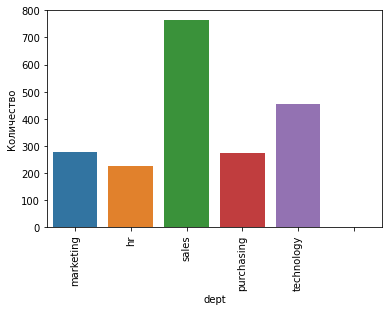

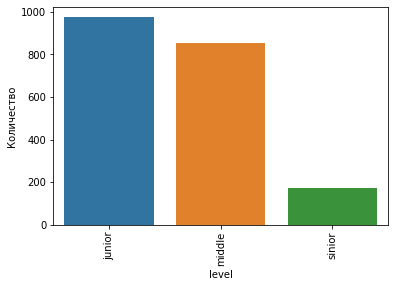

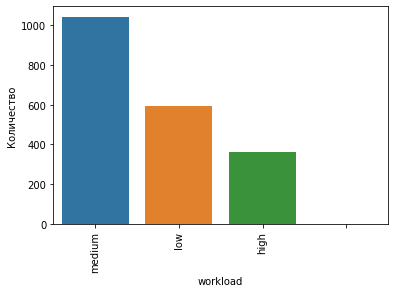

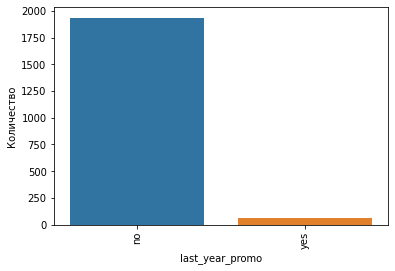

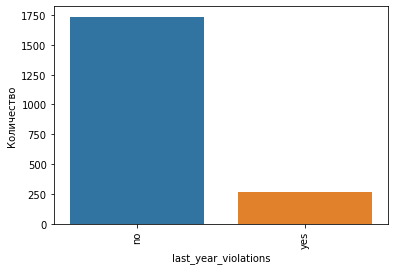

Гистограмма распределения значений для таблицы df_test_target_job_satisfaction_rate
Гистограмма распределения значений для таблицы df_test_target_quit


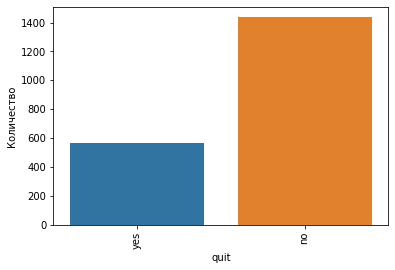

Гистограмма распределения значений для таблицы df_train_job_satisfaction_rate


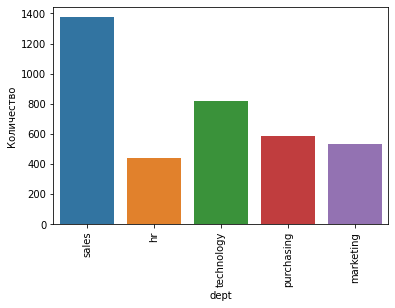

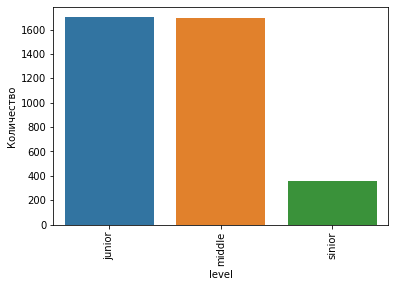

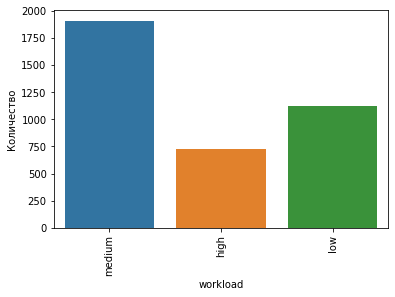

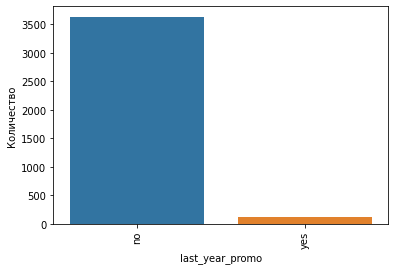

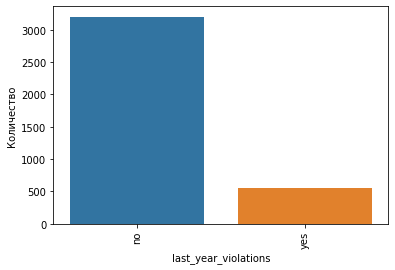

Гистограмма распределения значений для таблицы df_train_quit


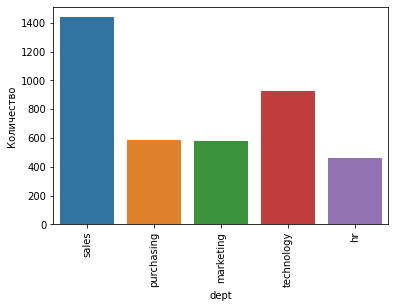

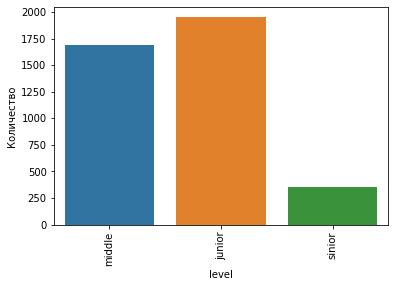

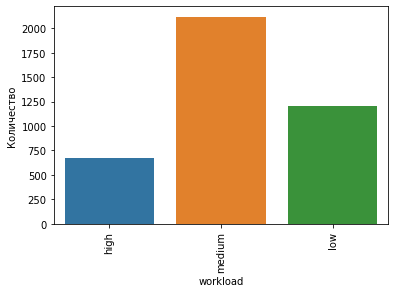

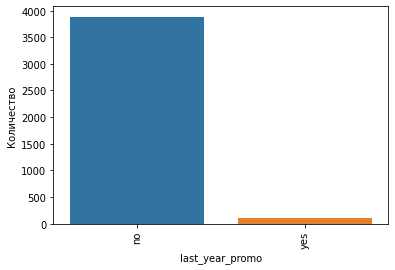

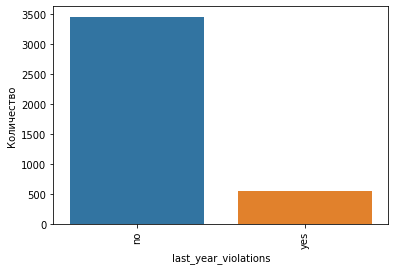

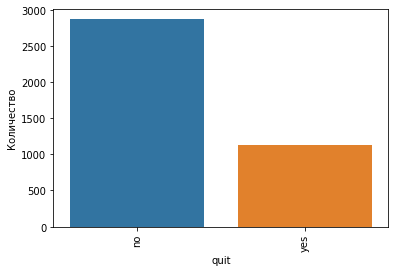

In [12]:
for f in DF_NAMES:
    print(f'Гистограмма распределения значений для таблицы {f}')
    for c in globals()['col_cat_' + f.strip('df_')]:
        ax = sns.countplot(x=c, data = globals()[f])
        ax.set(xlabel=c, ylabel='Количество')
        plt.xticks(rotation=90)
        plt.show()

По гистограммам можно сделать следующие наблюдения. Вцелом распределение данных поддается логике и ожидаемо. В наборе данных наблюдается сравнительно мизерное количество сотрудников с повышением ЗП. в таблице целевых признакам наблюдается дисбаланс признаков.

####  Построю для численных данных пару графиков гистограмму и ящик с усами, а заодно тест Колмогорова-Смирнова, чтобы получить нормальность распределения.

"Пара графиков для таблицы df_test_features


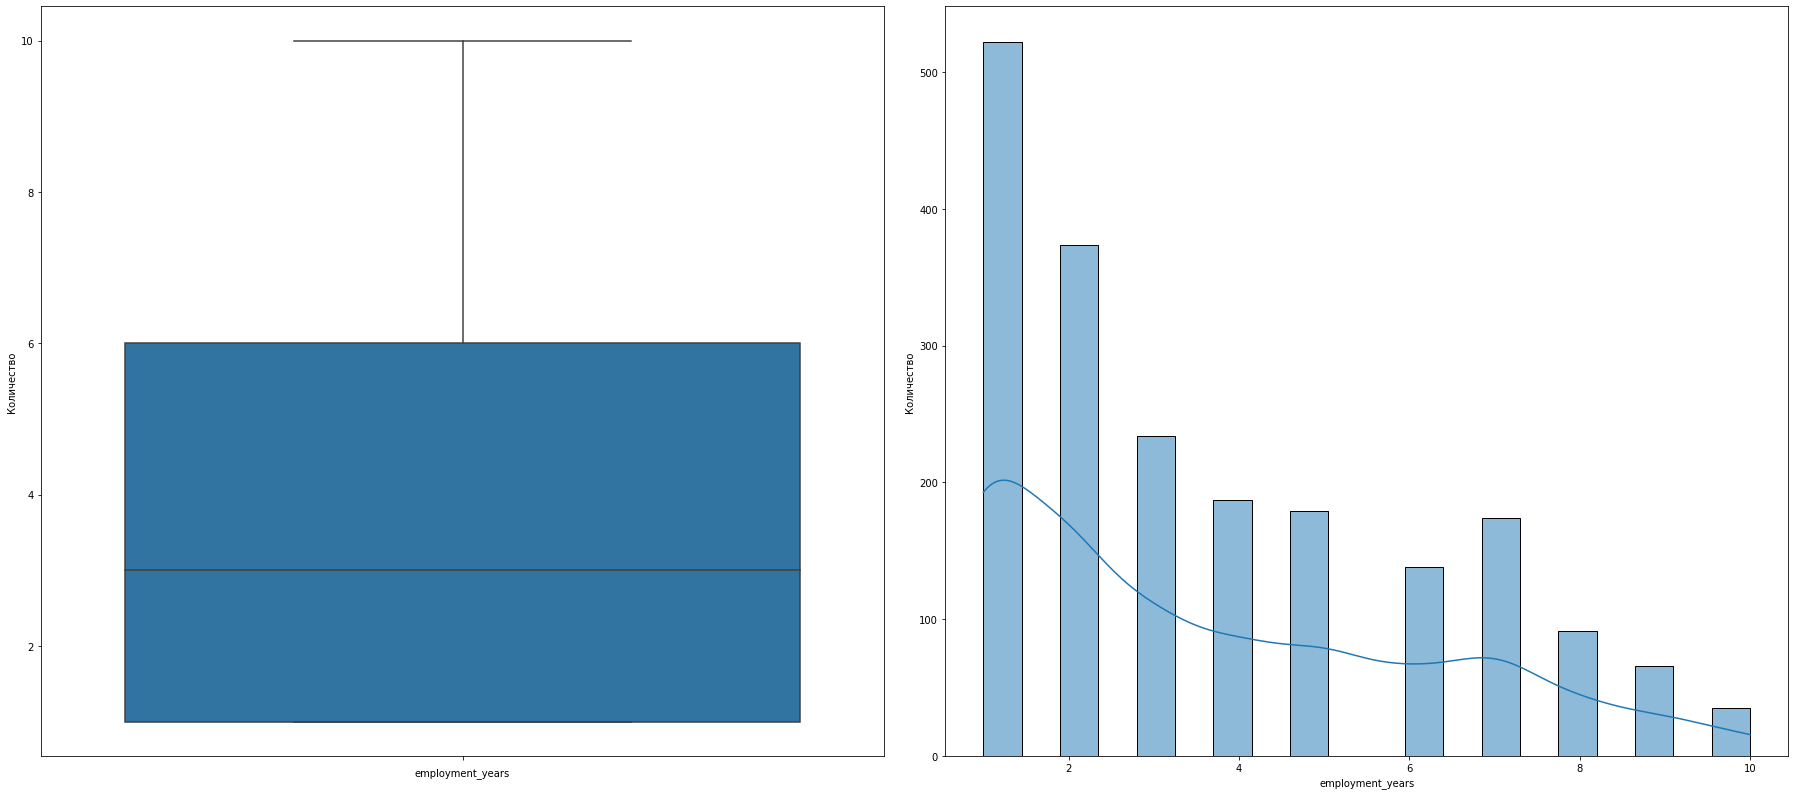

KstestResult(statistic=0.8413447460685429, pvalue=0.0)


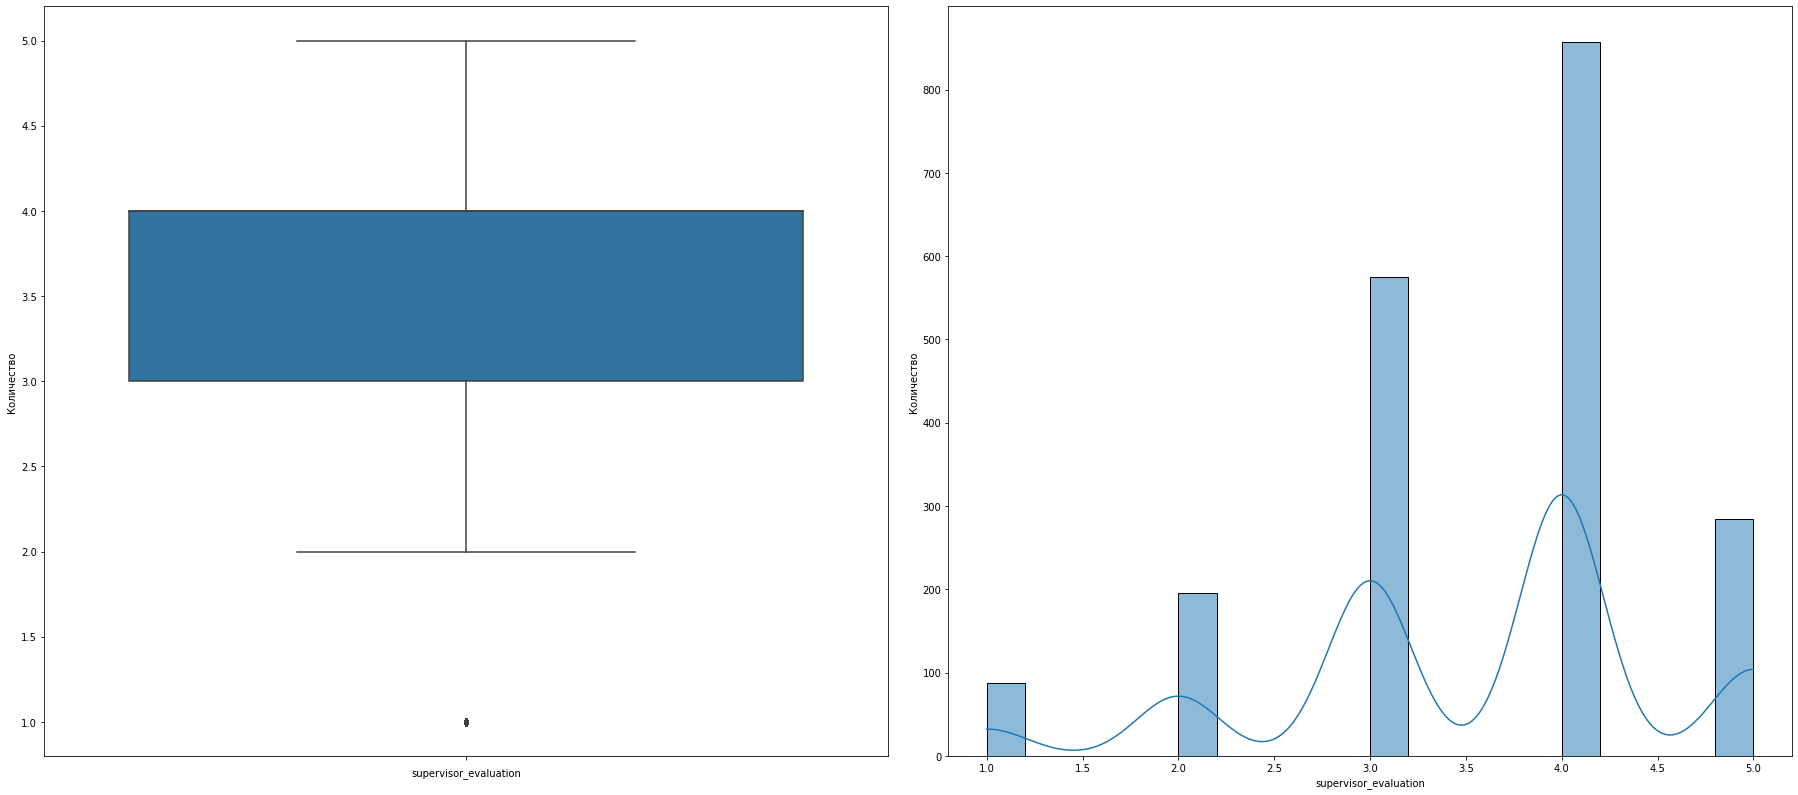

KstestResult(statistic=0.9332498680518208, pvalue=0.0)


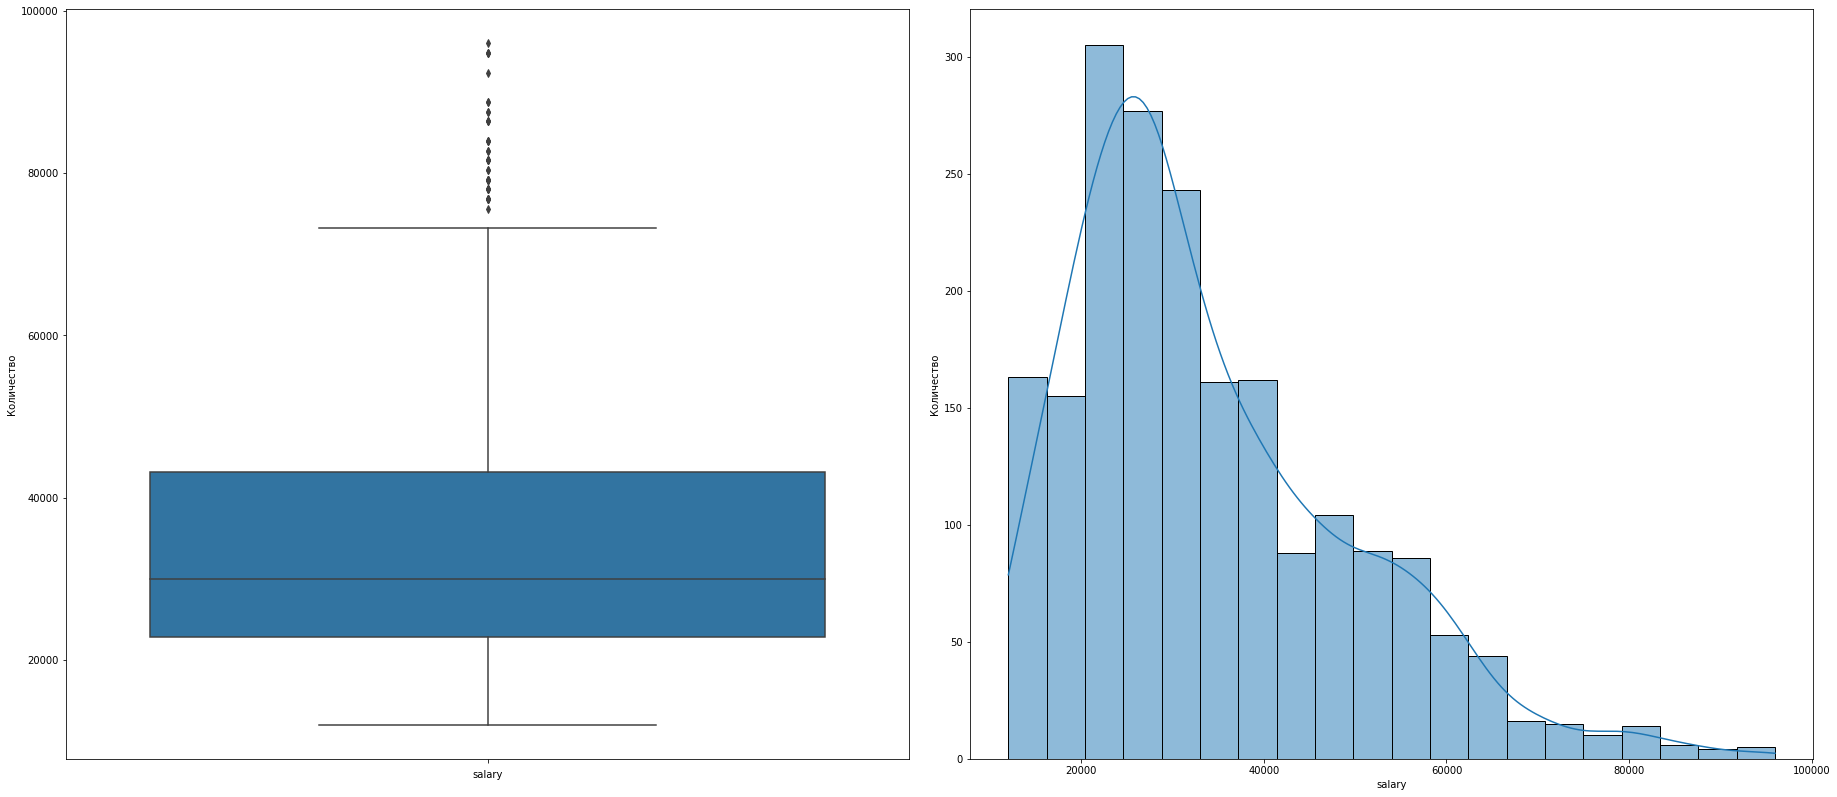

KstestResult(statistic=1.0, pvalue=0.0)
"Пара графиков для таблицы df_test_target_job_satisfaction_rate


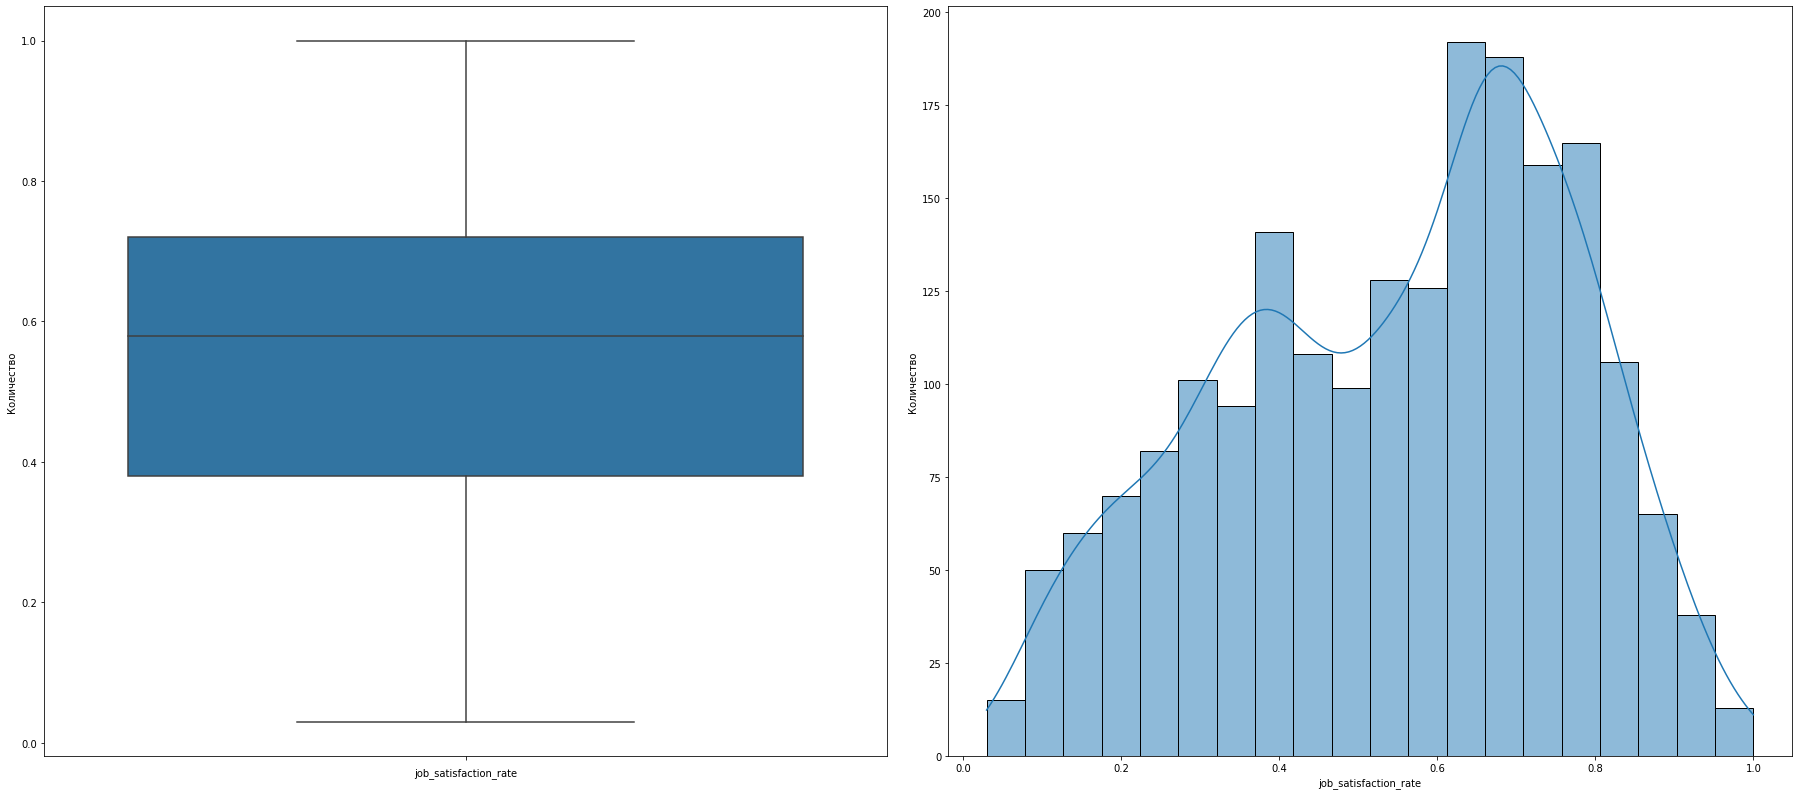

KstestResult(statistic=0.5263563925851722, pvalue=0.0)
"Пара графиков для таблицы df_test_target_quit
"Пара графиков для таблицы df_train_job_satisfaction_rate


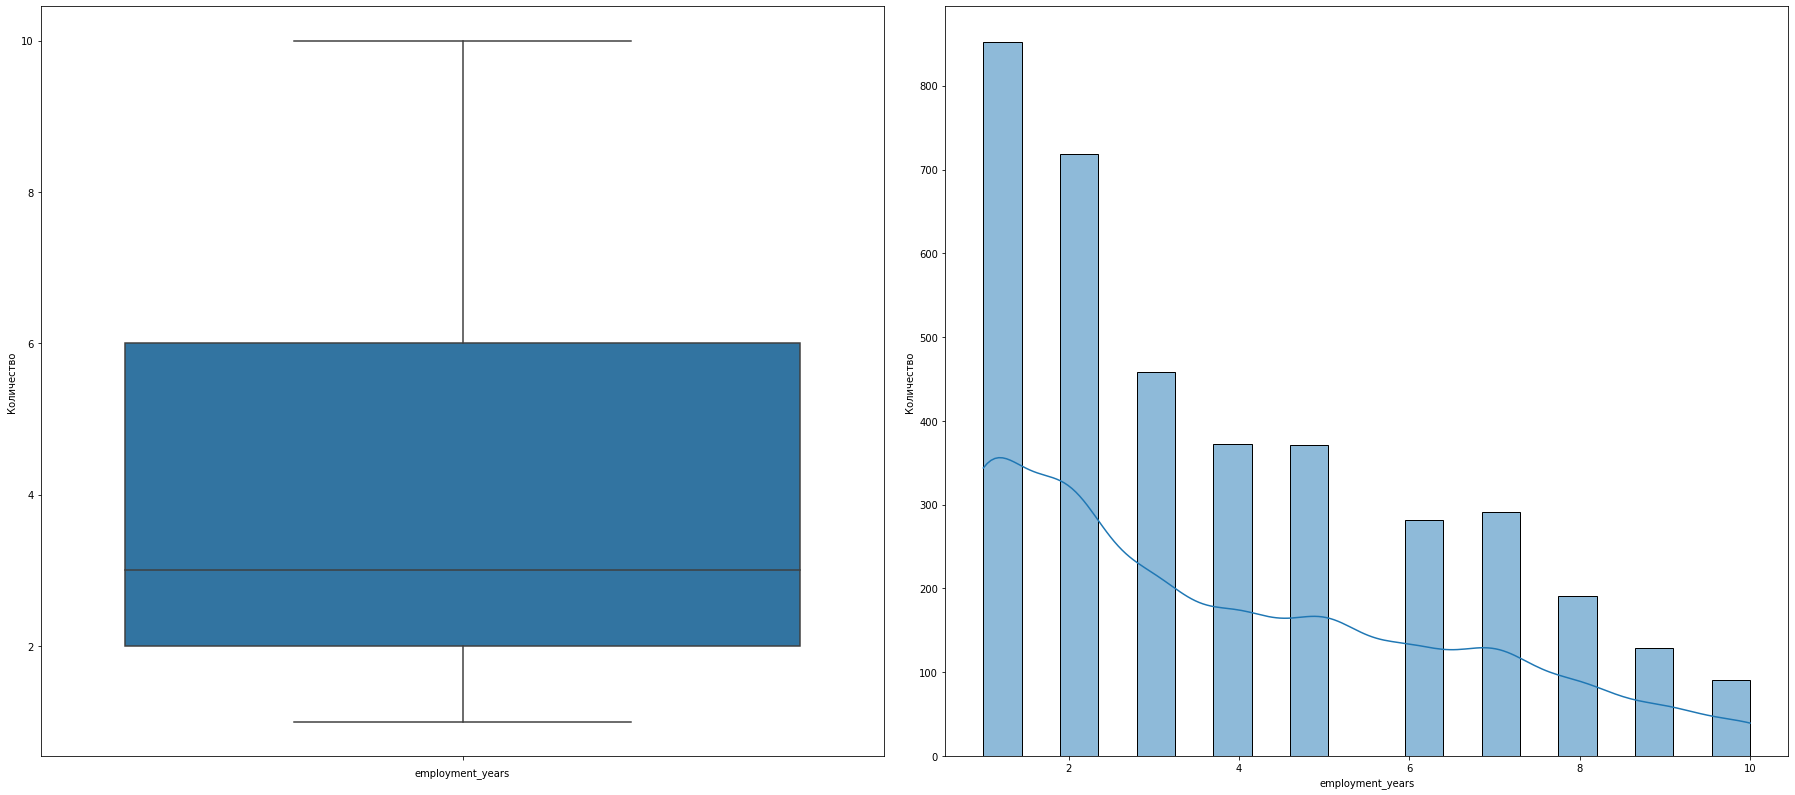

KstestResult(statistic=0.8413447460685429, pvalue=0.0)


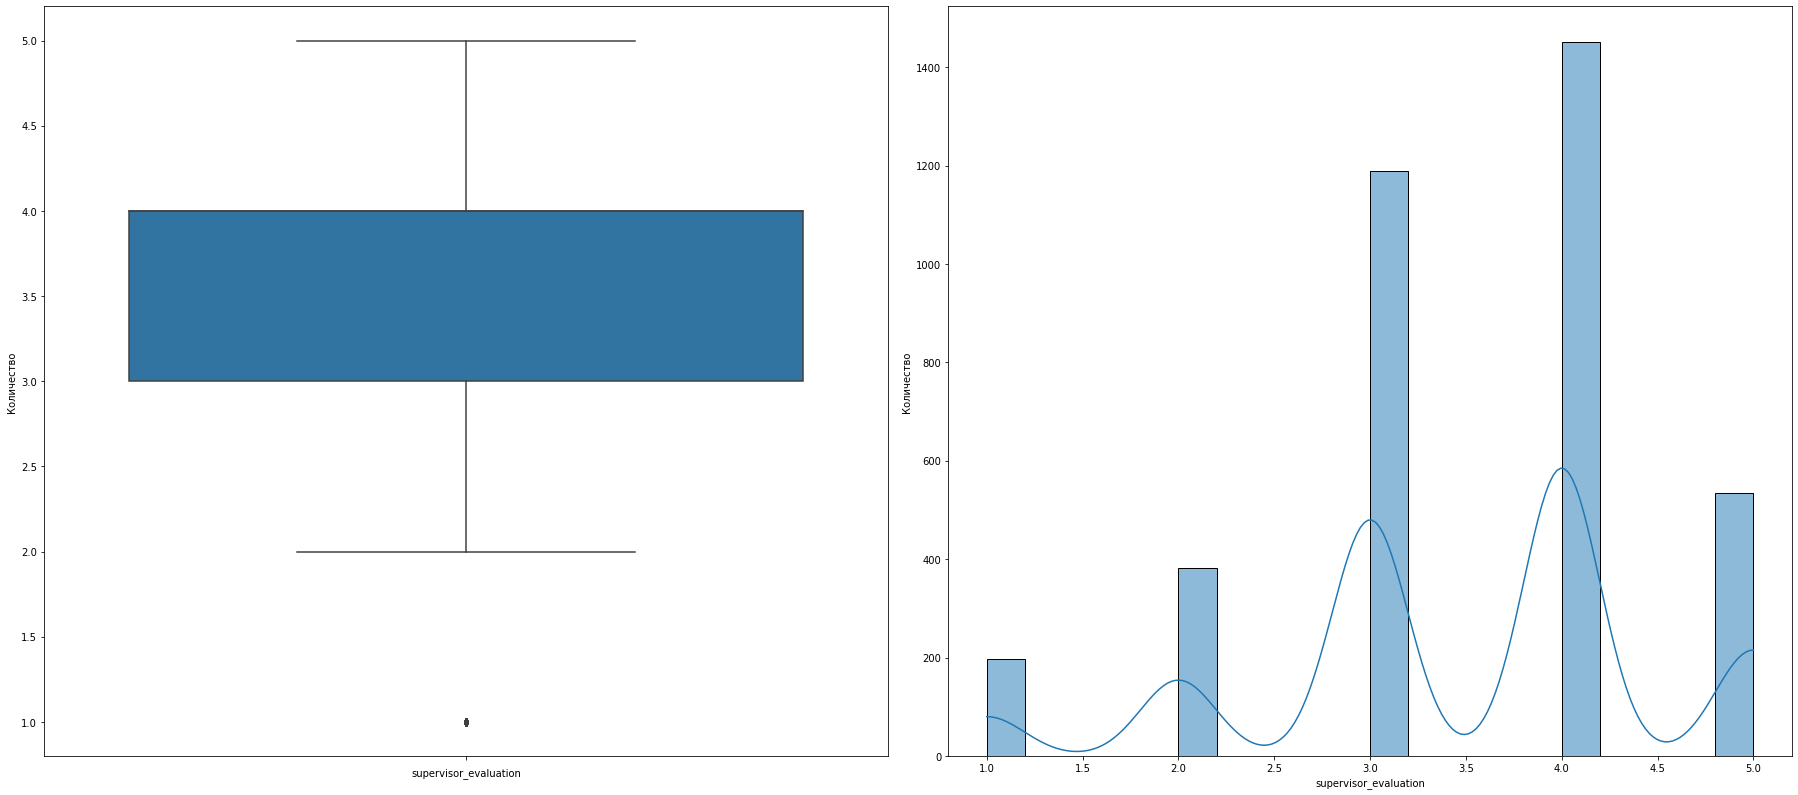

KstestResult(statistic=0.924520174310143, pvalue=0.0)


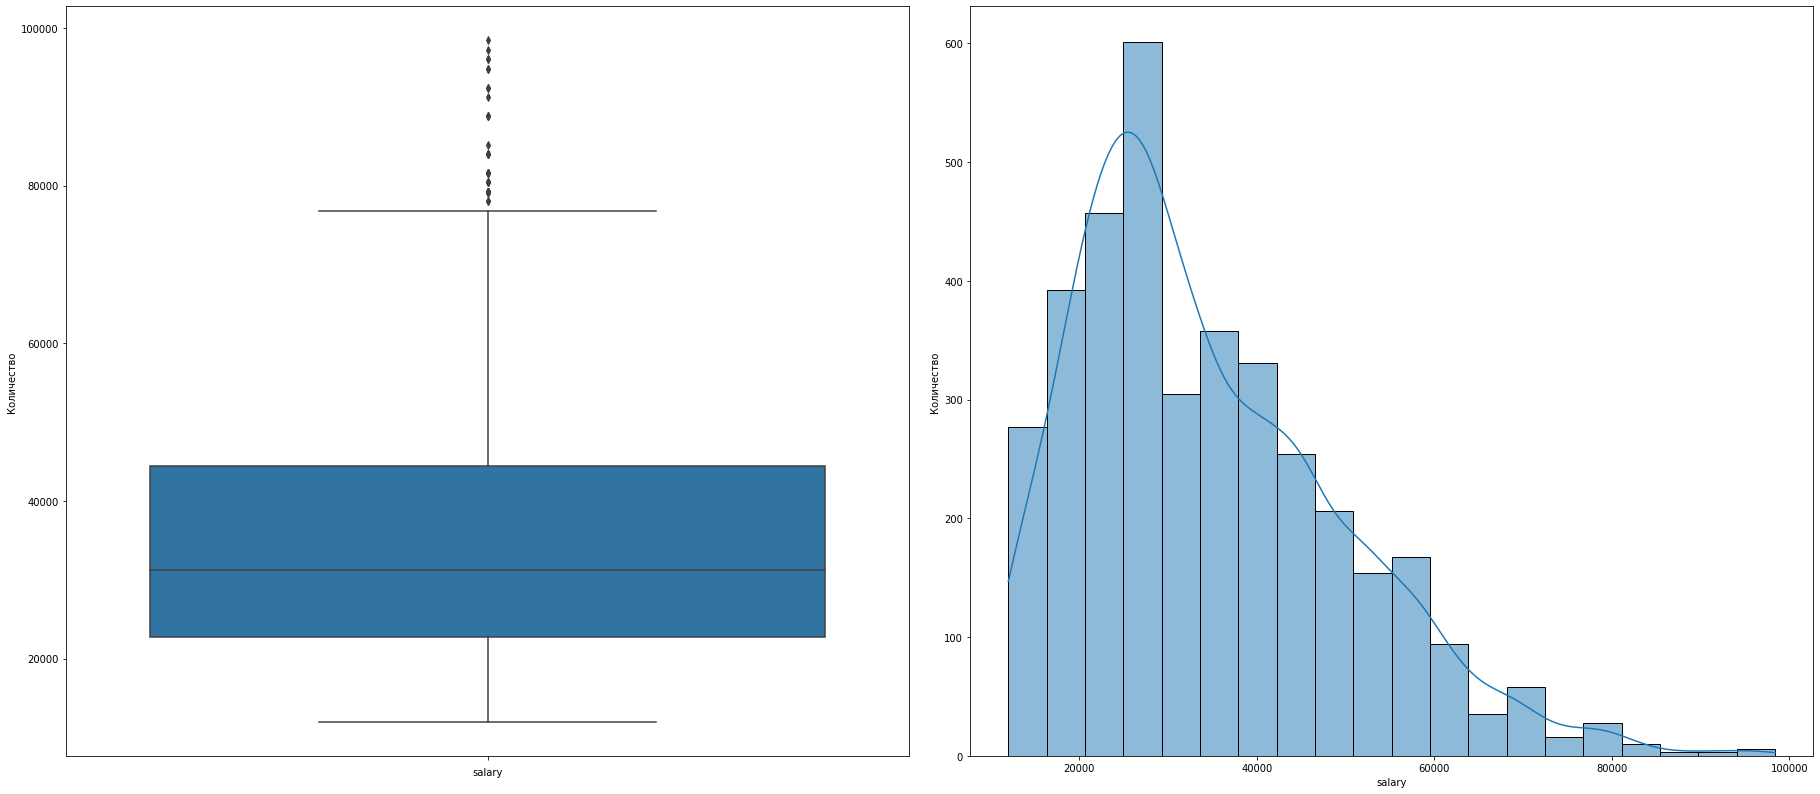

KstestResult(statistic=1.0, pvalue=0.0)


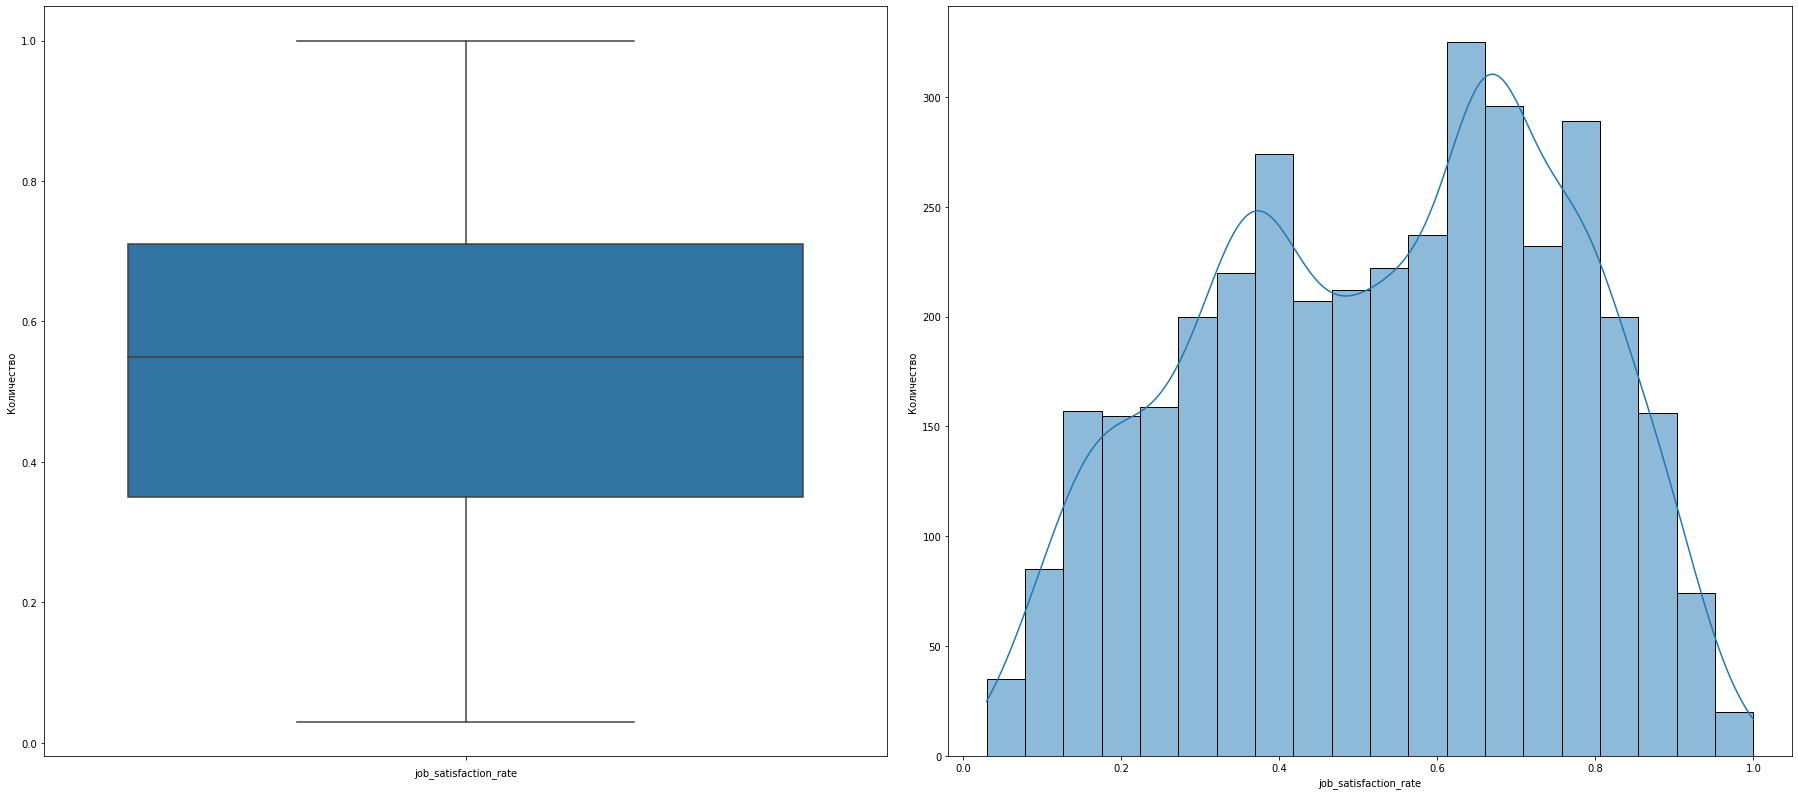

KstestResult(statistic=0.5236060596956914, pvalue=0.0)
"Пара графиков для таблицы df_train_quit


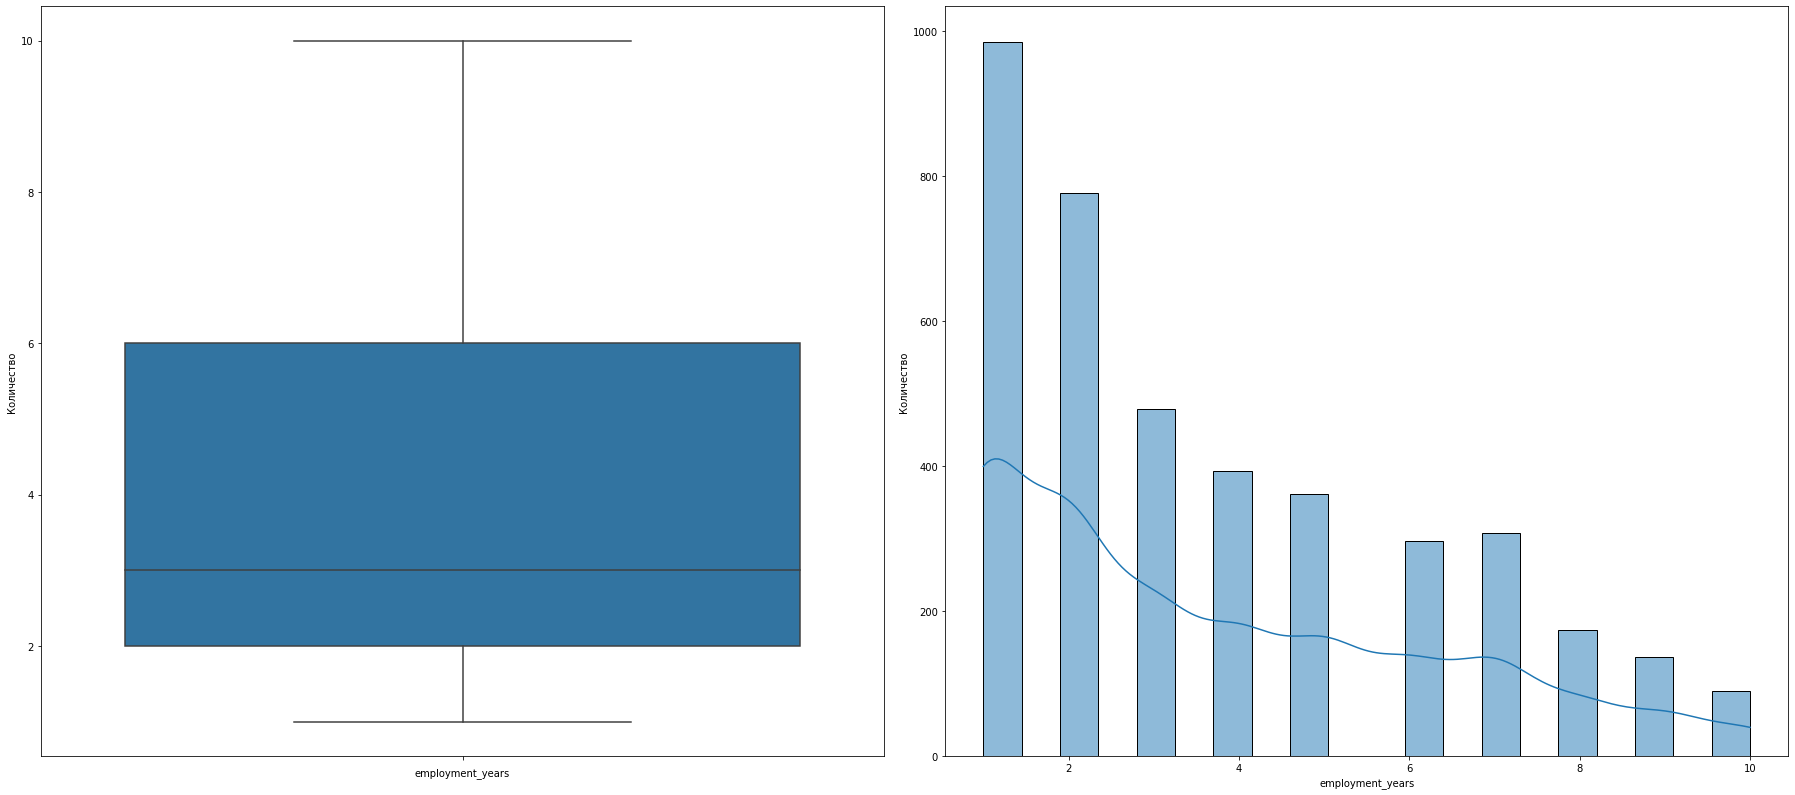

KstestResult(statistic=0.8413447460685429, pvalue=0.0)


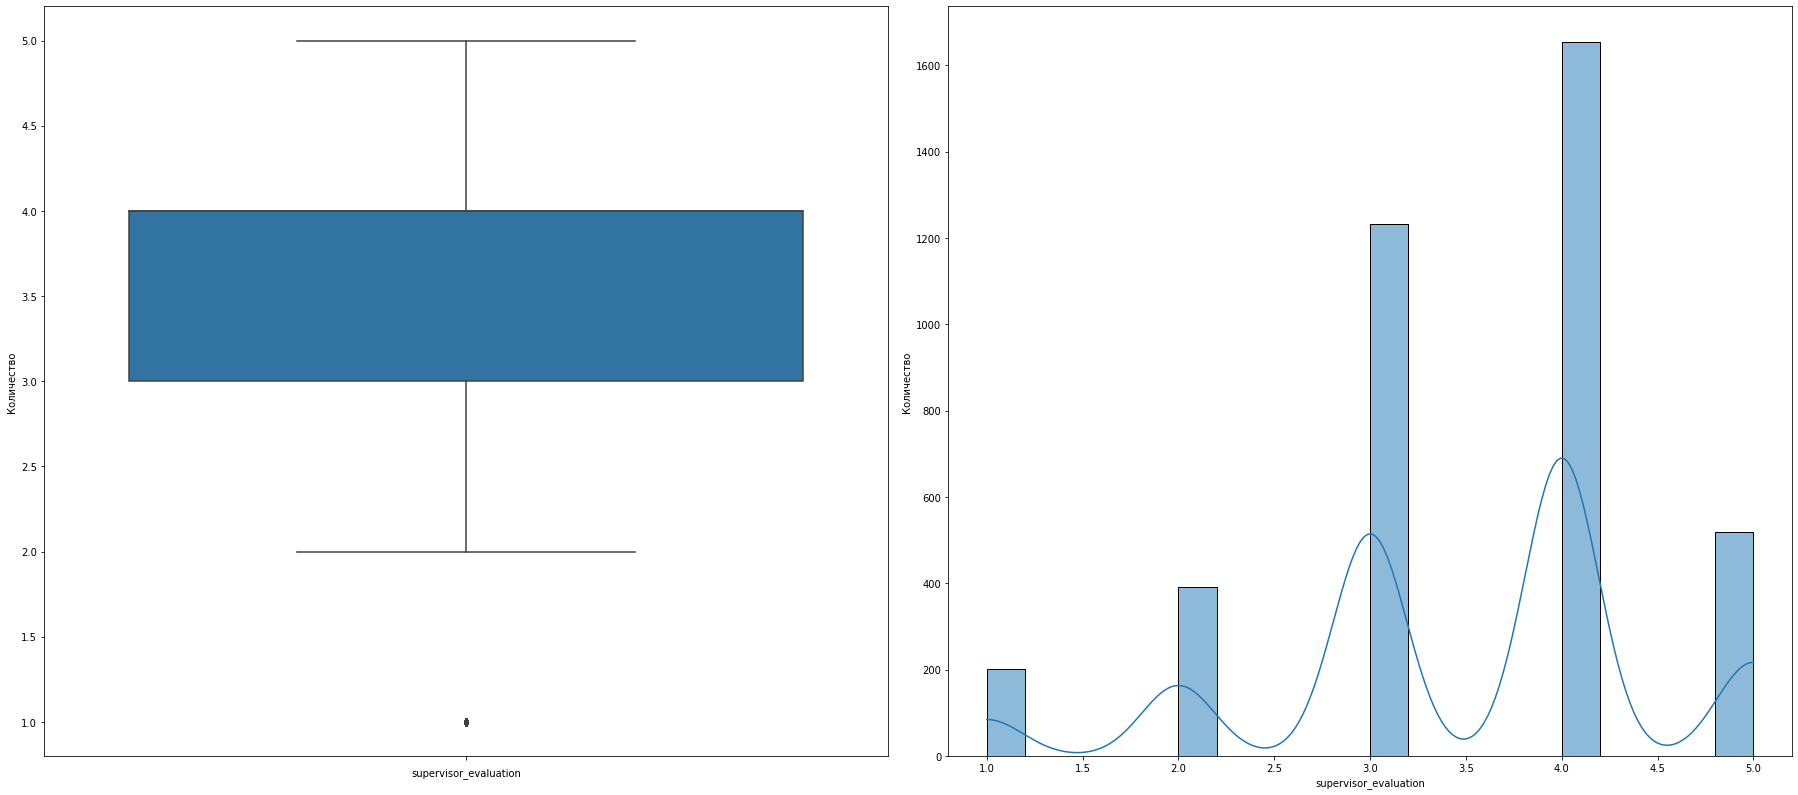

KstestResult(statistic=0.9267498680518208, pvalue=0.0)


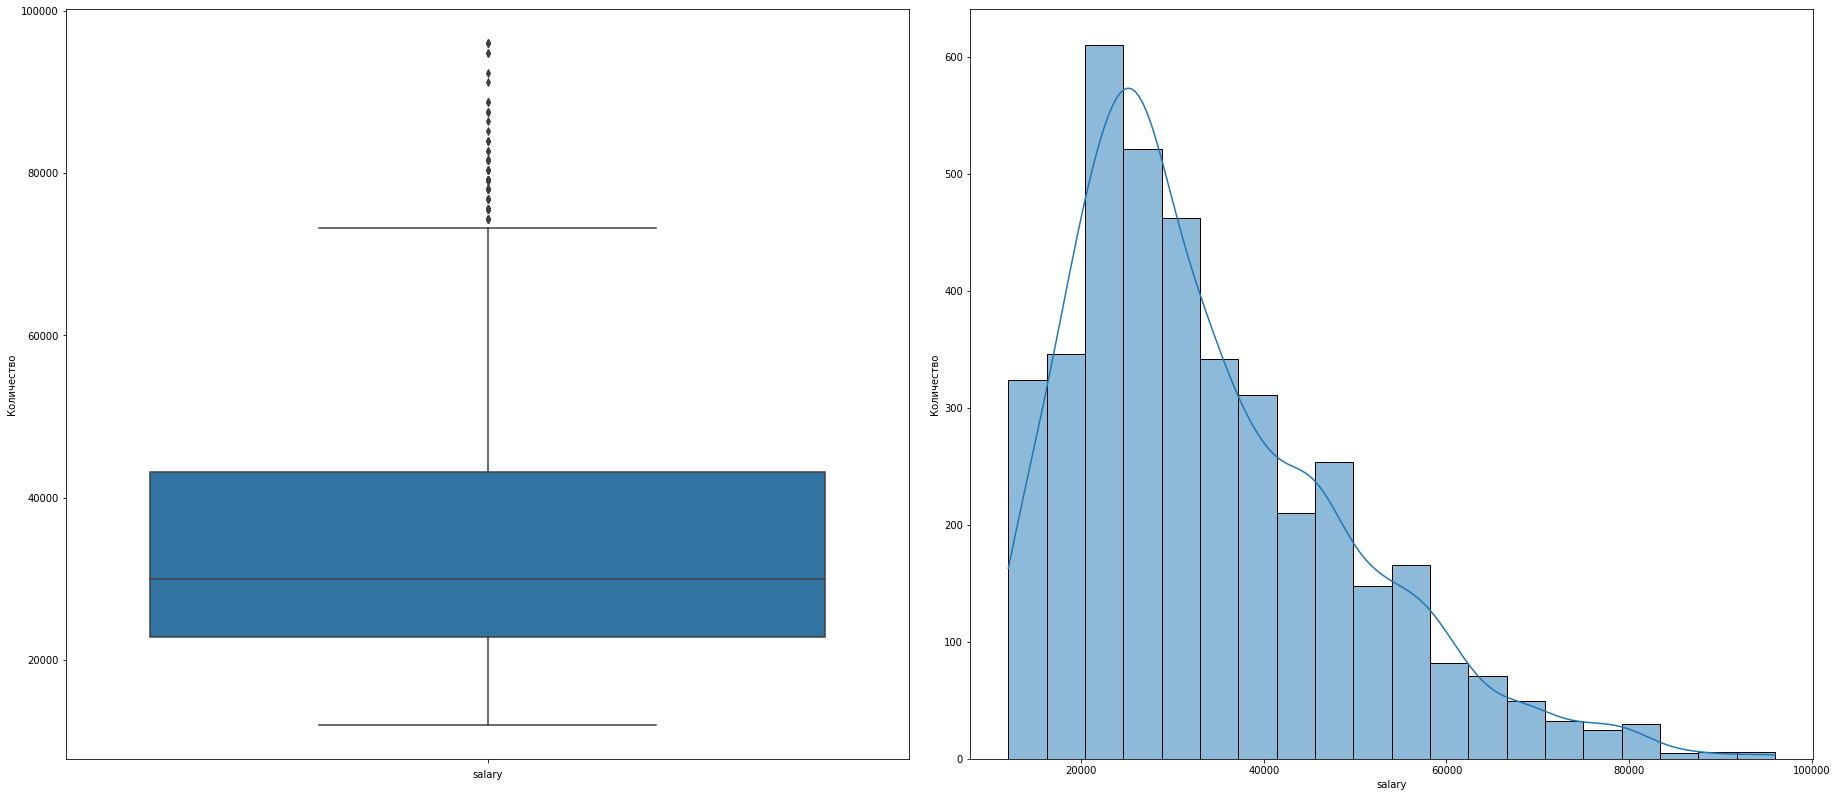

KstestResult(statistic=1.0, pvalue=0.0)


In [13]:
for f in DF_NAMES[:5]:
    print(f'"Пара графиков для таблицы {f}')
    for c in globals()['col_num_' + f.strip('df_')]:
        if c != 'id':
            fig, axes = plt.subplots(1,2, figsize=(25, 11), constrained_layout=False)
            fig.tight_layout(h_pad=10,w_pad=3)
            axes = axes.ravel()
            ax = sns.boxplot(y=c, data=globals()[f], ax=axes[0])
            ax.set(xlabel=c, ylabel='Количество')
            ax = sns.histplot(x=c, data = globals()[f], bins=20, kde=True)
            ax.set(xlabel=c, ylabel='Количество')
            plt.show()
            print(kstest(globals()[f][c], 'norm'))

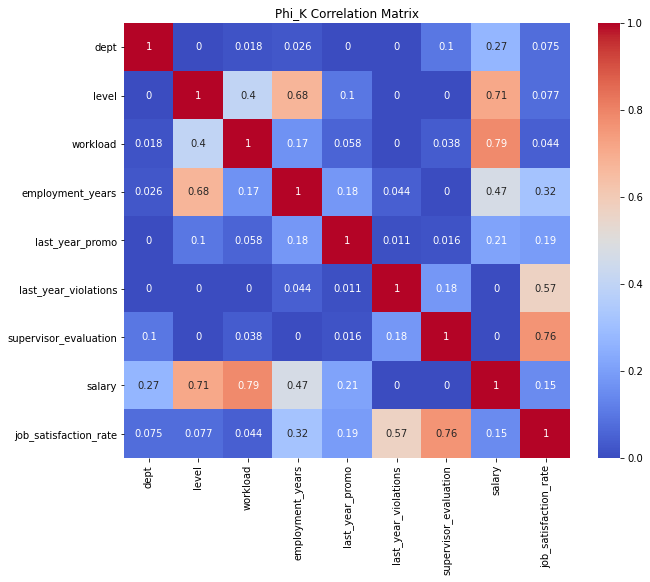

In [14]:
interval_cols = ['salary', 'job_satisfaction_rate']
corr_matrix = df_train_job_satisfaction_rate.phik_matrix(interval_cols= interval_cols)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

В таблице ниже я опишу каждый признак, его категорию и подкатегорию.  

|  Имя признака  | Описание признака  | Тип признака  |  Подтип признака  |  
|:----|:----|:---:|:---:|
|  dept  |  отдел, в котором работает сотрудник  |  Категориальный  |  Номинальный  |  
|  level  |  уровень занимаемой должности  |  Категориальный  |  Порядковый  |  
|  workload  |  уровень загруженности сотрудника  |  Категориальный  |  Порядковый  |  
|  employment_years  |  длительность работы в компании (в годах)  |  Количественный  |  Дискретный  |  
|  last_year_promo  |  показывает, было ли повышение за последний год  |  Категориальный  |  Номинальный  |  
|  last_year_violations  |  показывает, нарушал ли сотрудник трудовой договор за последний год  |  Категориальный  |  Номинальный  |  
|  supervisor_evaluation  |  оценка качества работы сотрудника, которую дал руководитель  |  Количественный  |  Дискретный  |  
|  salary  |  ежемесячная зарплата сотрудника  |  Количественный  |  Непрерывный  |  
|  job_satisfaction_rate  |  уровень удовлетворённости сотрудника работой в компании, целевой признак  |  Количественный  |  Непрерывный  |  

Выводом станет распределение имен колонок по спискам в константах, которые будут в дальнейшем использованы в паплайнах.

In [15]:
OHE_COLUMNS = ['dept']
ORD_COLUMNS = ['level', 'workload']
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary']
BIN_COLUMNS = ['last_year_promo', 'last_year_violations']

#### Построю диаграмму рассеяния для зависимости целевого признака от признаков.

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


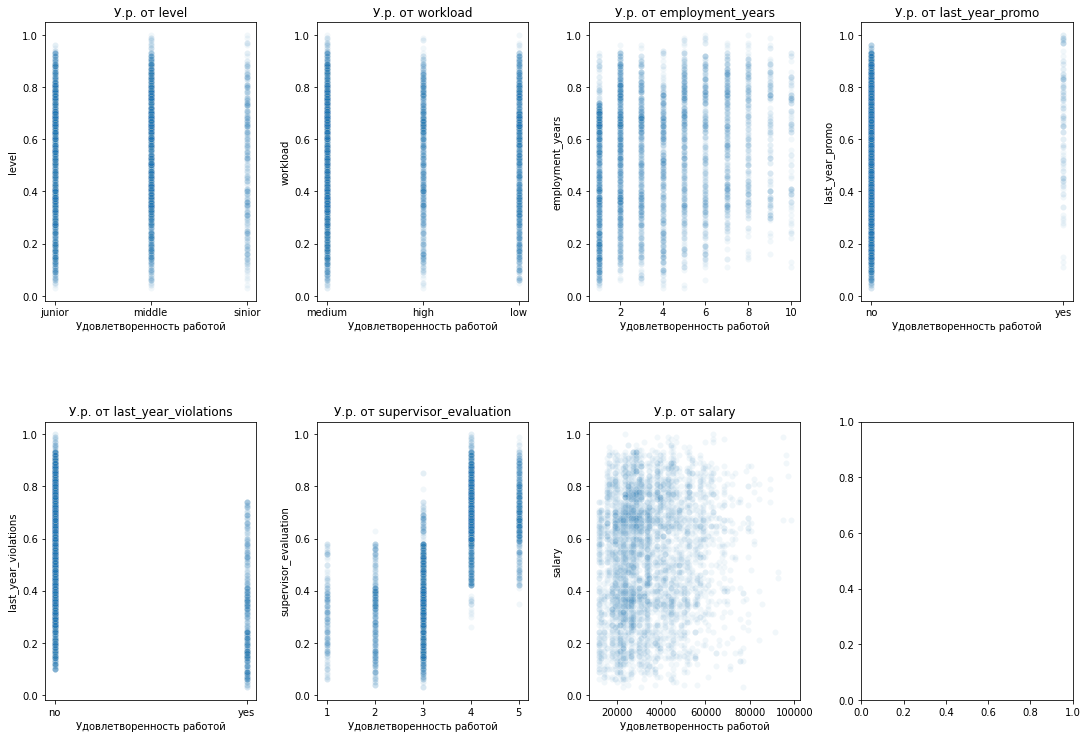

In [16]:
x=0
fig, axes = plt.subplots(2,4, figsize=(15, 10), constrained_layout=True)
fig.tight_layout(h_pad=10,w_pad=3)
axes = axes.ravel()
for col in df_train_job_satisfaction_rate.columns.to_list()[1:-1]:
    ax = sns.scatterplot(data=df_train_job_satisfaction_rate, y='job_satisfaction_rate', x=col, ax=axes[x], alpha=0.06)
    ax.set(xlabel='Удовлетворенность работой', ylabel=col, title=('У.р. от ' + col))
    x+=1

<a id='t004'></a>  
#  4. Подготовка данных

### Исправлю порядок в тестовых данных

In [17]:
df_test = df_test_features.merge(df_test_target_job_satisfaction_rate, how = 'left', left_on='id', right_on='id')
display(df_test)

dept   level workload  employment_years last_year_promo  \
id                                                                      
485046   marketing  junior   medium                 2              no   
686555          hr  junior   medium                 1              no   
467458       sales  middle      low                 5              no   
418655       sales  middle      low                 6              no   
789145          hr  middle   medium                 5              no   
...            ...     ...      ...               ...             ...   
393147   marketing  junior      low                 3              no   
109582  technology  middle      low                 3              no   
305653  technology  junior      low                 1              no   
160233  technology  middle      low                 8              no   
771859  purchasing  middle   medium                 1              no   

       last_year_violations  supervisor_evaluation  salary  \
id                                                           
485046                   no                      5   28800   
686555                   no                      4   30000   
467458                   no                      4   19200   
418655                   no                      4   19200   
789145                   no                      5   40800   
...                     ...                    ...     ...   
393147                   no                      3   20400   
109582                   no                      2   21600   
305653                   no                      3   14400   
160233                   no                      1   32400   
771859                   no                      4   38400   

        job_satisfaction_rate  
id                             
485046                   0.79  
686555                   0.72  
467458                   0.64  
418655                   0.60  
789145                   0.75  
...                       ...  
393147                   0.56  
109582                   0.14  
305653                   0.11  
160233                   0.43  
771859                   0.67  

[2000 rows x 9 columns]

### Объявлю конвеер для OneHotEncoder

In [18]:
r_o_s = RandomOverSampler(random_state = RANDOM_STATE)

In [19]:
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [20]:
bin_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary'))
])

In [21]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

Объявлю конвеер для OrdinalEncoder

In [22]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', 
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(strategy='most_frequent')
        )
    ]
)

Собираю все вместе и добавляю обработку численных признаков MinMaxScaler'ом

In [23]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, NUM_COLUMNS),
        ('bin', bin_pipe, BIN_COLUMNS),
        ('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS)
        
    ], 
    remainder='passthrough'
) 

<a id='t005'></a>  
#  5. Обучение моделей

Объявлю метрику из заранее созданной функции

In [24]:
smape_score = make_scorer(smape, greater_is_better=False)

Объявлю словарь гиперпараметров моделей

In [25]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,300), 
        'models__min_samples_leaf': [2, 3 , 4, 5, 6, 7],
        'models__min_samples_split': [2, 4, 6],
        'models__max_leaf_nodes': range(2,300),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Итоговый паплайн

In [26]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Определю автоматический поиск моделей через RandomizedSearchCV

In [27]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring=smape_score, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Выделю из тренировочной выбоки целевые признаки

In [28]:
X_train = df_train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis = 1)
y_train = df_train_job_satisfaction_rate['job_satisfaction_rate']
x_test = df_test.drop(['job_satisfaction_rate'], axis = 1)
y_test = df_test['job_satisfaction_rate']

In [29]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['employment_years',
                                                                                'supervisor_evaluation',
                                                                                'salary']),
                                                                              ('bin',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('one...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [30]:
print(f'\n Лучший результат метрики по всем гиперпараметрам: {(-randomized_search.best_score_):.2f}')
print(f'\n Лучшие переметры среди всех гиперпараметров:\n {randomized_search.best_params_}')
print(f'\n Метрика SMAPE на тестовой выборке: {smape(y_test, randomized_search.predict(df_test_features)):.2f}')


 Лучший результат метрики по всем гиперпараметрам: 14.82

 Лучшие переметры среди всех гиперпараметров:
 {'preprocessor__num': MinMaxScaler(), 'models__min_samples_split': 4, 'models__min_samples_leaf': 2, 'models__max_leaf_nodes': 263, 'models__max_depth': 134, 'models': DecisionTreeRegressor(random_state=42)}

 Метрика SMAPE на тестовой выборке: 13.46


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


<a id='t006'></a>  
#  6. Вывод Задачи-1

Лучшей моделью оказалось дерево решений. Причиной тому стало отсутствие нормализации в тренировочных признаках и наличие выбросов. С этими задачами линейные модели справляются значительно хуже.

# Задача-2

Некоторые шаги описанные в задании я уже выполнил ранее. Я их пропущу и перейду сразу к анализу данных.

<a id='t007'></a>  
#  Анализ данных

Составлю портрет уволившегося сотрудника. df_train_quit

## Для простоты понимания характера увольняющегося сотрудника визуализирую его круговыми диаграммами.

In [31]:
a = b = 1
col_names = ['dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
specs=[[{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}],
       [{"type": "pie"},{"type": "pie"},{"type": "pie"},{"type": "pie"}]]

from plotly.subplots import make_subplots
import plotly.graph_objects as go
df_quets = df_train_quit[df_train_quit['quit'] == 'yes']
fig = make_subplots(rows=2, 
                    cols=4, 
                    specs = specs, 
                    subplot_titles = col_names)

for col in col_names:
    fig.append_trace(go.Pie(values = df_quets[col].value_counts(normalize=True), 
                         hole=.3, 
                         labels=df_quets[col].unique(), 
                         textinfo='label+percent'), 
                            row = b, 
                            col = a)#,
                            
    fig.update_layout(autosize=False, 
                      width=800, 
                      height=600, 
                      margin=dict(dict(l=50, r=50, b=0, t=50, pad=0)),
                      showlegend=False
                      )
    a += 1
    if a == 5:
        b += 1
        a = 1
fig.show()

### Описательный портрет увольняющегося сотрудника.

Из полученных выше графиков можно сделать вывод, что чаше всего покидают компанию младшие сотрудники из отдела продаж имеющие среднюю оценку руководителя с не высокой загрузкой проработавшие 1-2 года без повышения ЗП имеющий нарушения трудового договора.

<a id='t008'></a>  
## Проверю предположение аналитиков о том, что уровлетворенность работой влияет на увольнение сотрудника

Объединю данные из двух таблий, для удобства дальнейшей работы.

In [32]:
df_temp = df_test_target_job_satisfaction_rate.merge(df_test_target_quit, left_on='id', right_on='id' )

Построю диаграмму для признака

In [33]:
import plotly.express as px
fig = px.histogram(df_temp, x="job_satisfaction_rate", color="quit", nbins=20)
fig.update_layout(autosize=False, width=1000, height=700)
fig.show()

<a id='t009'></a>  
# Добавление нового входного признака

In [34]:
df_train_quit['satis'] = randomized_search.predict(df_train_quit)
df_test_features['satis'] = randomized_search.predict(df_test_features)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



<a id='t010'></a>  
# Подготовка данных

In [35]:
df_test_features = df_test_features.merge(df_test_target_quit, on='id')
X_test = df_test_features.drop(['quit', 'dept'], axis=1)
y_test = df_test_features['quit']
X_train = df_train_quit.drop(['quit', 'dept'], axis=1)
y_train = df_train_quit['quit']

In [36]:
NUM_COLUMNS = ['employment_years', 'supervisor_evaluation', 'salary', 'satis']
#ORD_COLUMNS = ['level', 'workload']
#BIN_COLUMNS = ['last_year_violations']

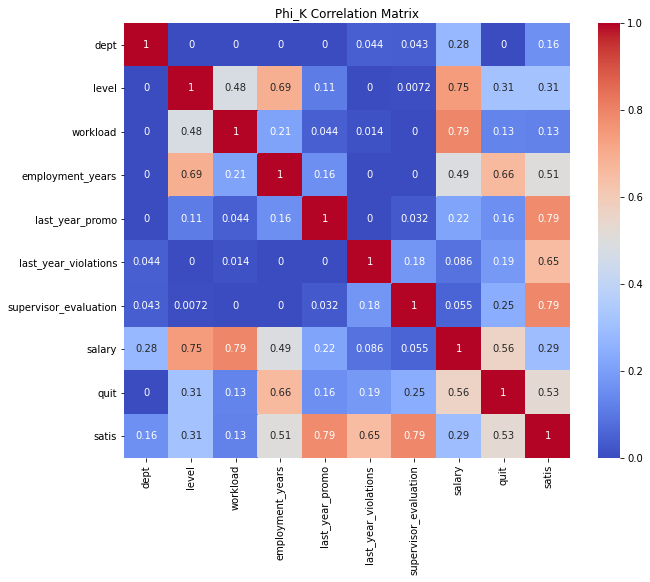

In [37]:
corr_matrix = df_train_quit.phik_matrix(interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'satis'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Закодирую целевые признаки

In [38]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [39]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'no': 0, 'yes': 1}


In [40]:
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [41]:
bin_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='if_binary'))
])

In [42]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
) 

Объявлю конвеер для OrdinalEncoder

In [43]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', 
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Собираю все вместе препроцессор

In [44]:
data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, NUM_COLUMNS),
        ('bin', bin_pipe, BIN_COLUMNS),
        #('ohe', ohe_pipe, OHE_COLUMNS),
        ('ord', ord_pipe, ORD_COLUMNS)
        
    ], 
    remainder='passthrough'
) 

In [45]:
param_grid = [
    
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l2')],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', penalty='l2', max_iter=10000)],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=10000)],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },
    
    
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4, max_features=4)],
        'model__max_depth': range(3, 7),
        'model__max_features': range(3, 7),
        'model__min_samples_leaf': range(2, 3),
        'model__min_samples_split': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(4, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE,
                kernel='rbf',
                gamma=0.28)
        ],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    },
    

    {
        'model': [
            SVC(
                probability=True,
                random_state=RANDOM_STATE,
                kernel='poly',
                gamma=0.28)
        ],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__degree': [4, 6, 8],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),]
    }
]

In [46]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', penalty='l2'))
    ]
)

In [47]:
rs = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

<a id='t011'></a>
#  Обучение модели

In [48]:
rs.fit(X_train, y_train_encoded)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['employment_years',
                                                                                'supervisor_evaluation',
                                                                                'salary',
                                                                                'satis']),
                                                                              ('bin',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent'...
                                        {'model': [SVC(gamma=0.28,
                                                       probability=True,
                                                       random_state=42)],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'model': [SVC(gamma=0.28,
                                                       kernel='poly',
                                                       probability=True,
                                                       random_state=42)],
                                         'model__C': [0.01, 0.1, 1, 10, 100],
                                         'model__degree': [4, 6, 8],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

Подготовлю тестовые данные добавив столбец у

In [49]:
pred = rs.predict_proba(X_test)[:, 1]

In [50]:
display(pred)

array([0.00450783, 0.0810588 , 0.03445366, ..., 0.99999665, 0.01678625,
       0.06367108])

In [51]:
#print("\n Лучшая модель:\n", randomized_search.best_estimator_)
print(f'\n Лучший результат метрики по всем гиперпараметрам: {(rs.best_score_):.2f}')
print(f'\n Лучшие переметры среди всех гиперпараметров:\n {rs.best_params_}')
print(f'\n Метрика на тестовой выборке: {roc_auc_score(y_test_encoded, pred):.2f}')


 Лучший результат метрики по всем гиперпараметрам: 0.93

 Лучшие переметры среди всех гиперпараметров:
 {'preprocessor__num': MinMaxScaler(), 'model__C': 10, 'model': SVC(gamma=0.28, probability=True, random_state=42)}

 Метрика на тестовой выборке: 0.93


In [52]:
model = rs.best_estimator_.named_steps['model']
print(model)
df_named =pd.DataFrame(rs.best_estimator_['preprocessor'].transform(X_train), 
                                              columns=X_train.columns.to_list())

SVC(C=10, gamma=0.28, probability=True, random_state=42)


In [53]:
display(df_named)

level  workload  employment_years  last_year_promo  \
0     0.111111      0.75          0.500000         0.653136   
1     0.111111      0.75          0.185714         0.849258   
2     0.444444      0.00          0.300000         0.339456   
3     0.111111      0.50          0.142857         0.325813   
4     0.111111      1.00          0.157143         0.849258   
...        ...       ...               ...              ...   
3995  0.333333      0.50          0.171429         0.492907   
3996  0.888889      0.75          0.485714         0.856501   
3997  0.111111      0.75          0.000000         0.533827   
3998  0.111111      0.75          0.257143         0.480510   
3999  0.111111      0.50          0.185714         0.510907   

      last_year_violations  supervisor_evaluation  salary  satis  
0                      0.0                    0.0     1.0    2.0  
1                      0.0                    0.0     0.0    1.0  
2                      0.0                    0.0     1.0    1.0  
3                      0.0                    1.0     0.0    1.0  
4                      0.0                    0.0     0.0    1.0  
...                    ...                    ...     ...    ...  
3995                   0.0                    0.0     0.0    1.0  
3996                   0.0                    0.0     1.0    2.0  
3997                   0.0                    1.0     0.0    0.0  
3998                   0.0                    0.0     1.0    1.0  
3999                   0.0                    0.0     0.0    1.0  

[4000 rows x 8 columns]

<a id='t012'></a>
#  Визуализация важности признаков

In [54]:
shap.initjs()
X_sub = shap.sample(df_named, 10)
explainer = shap.KernelExplainer(model.predict_proba, X_sub)
shap_values = explainer.shap_values((rs.best_estimator_['preprocessor'].transform(X_test)))
shap.force_plot(explainer.expected_value[0], shap_values[0], (rs.best_estimator_['preprocessor'].transform(X_test)))

  0%|          | 0/2000 [00:00<?, ?it/s]

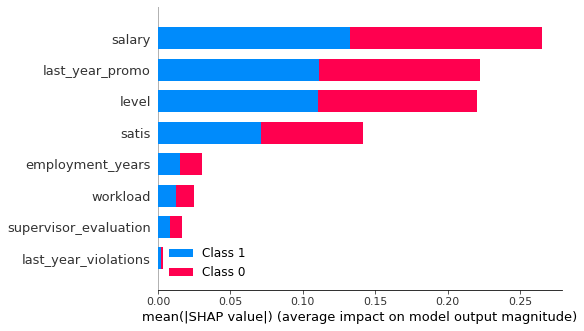

In [67]:
shap.summary_plot(shap_values, X_test)

Лучшей моделью оказалась SVC с ядром rbf. Причиной тому по моему мнению стала робастность модели. Она устойчива к выбросам, что ее выделяет в сравнении с линейными. 

<a id='t013'></a>
#  Общий вывод

 - **Описание задачи.**  
Цель исследования помочь бизнесу оптимизировать управление персоналом. С помощью машинного обучения необходимо решить две задачи: по полученным данным предсказать удовлетворенность сотрудника его работой и вторая часть это предсказать вероятность увольнения сотрудника. Это поможет оптимизировать бизнессу риски и расходы.

 - **Этапы работы.**  
 Для выполнения задания я загрузил полученные данные, произвел их предобработку и анализ. Создал конвеер для автоматизации предобработки, выбора оптимальной модели и гиперпараметров для нее. В ходе второй части задания я дополнил тренировочные и тестовые признаки спрогнозированными данными из первой части. А далее, так же через конвейеры, отобрал модель и ее параметры. Построил прогноз и выполнил оценку качества модели для тренировочных и тестовых данных. Финальным шагом я визуализировал важность параметров модели для составления рекомендаций в следующем пункте.  
 
 - **Выводы и рекомендации.**  
По первому заданию можно, опираясь на матрицу корреляции, сделать вывод, что на удовлетворенность сотрудником работой влияет в первую очередь уровень оценки руководителем, второй весомый признак это отсутствие нарушений за прошедший год. По второму заданию признаки выстроены по важности: Зарплата, Повышение за прошлый год, Уровень занимаемой должности.
Рекомендациями будет обращать внимание на соответствующий уровень зарплаты, периодически повышать оклад и мотивировать сотрудников карьерным ростом. Это поможет избежать ухода сотрудника.